## Install Package yang diperlukan

In [1]:
!pip install jcopdl
!pip install tqdm

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=3e56a08b8868ae9dde0ab7fe97961bc9cde2af4c6d2cf3a37a6060ccc2cf7fbf
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


## Import Package yang diperlukan

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block
from jcopdl.layers import linear_block, conv_block

from google.colab import files
import zipfile,os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Download Datasets dan Ekstraksi

In [3]:
!unrar x "/content/drive/My Drive/datasets/Intel_Image_Classification.rar" "/content/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/Intel_Image_Classification/train/sea/3497.jpg        70%  OK 
Extracting  /content/Intel_Image_Classification/train/glacier/3498.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/buildings/3499.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/street/35.jpg       70%  OK 
Extracting  /content/Intel_Image_Classification/train/street/3500.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/street/3501.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/street/3503.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/sea/3504.jpg        70%  OK 
Extracting  /content/Intel_Image_Classification/train/street/3505.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/buildings/3506.jpg      70%  OK 
Extracting  /co

## Datasest dan DataLoader

In [5]:
bs = 128
crop_size = 64

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("/content/Intel_Image_Classification/train/", transform=transform_train)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/Intel_Image_Classification/test/", transform=transform_test)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [6]:
# Cek Data
images, label = next(iter(trainloader))
images.shape

torch.Size([128, 3, 64, 64])

In [7]:
# label
label2cat = train_set.classes
label2cat

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [8]:
len(label2cat)

6

## Arsitektur CNN

In [9]:
class IntelCNN(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size, drout):
        super().__init__()
        self.conv = nn.Sequential(
            # 3x64x64
            nn.Conv2d(3, 16, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # 16x32x32
            nn.Conv2d(16, 32, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #32x16x16
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #64x8x8
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden1),
            nn.ReLU(),
            nn.Dropout(drout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(drout),
            nn.Linear(hidden2, output_size),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        return self.fc(self.conv(x))

In [10]:
# set config
config = set_config({
    "bs" : 128,
    "crop_size" : 64,
    "input_layer" : 4096,
    "hidden1" : 2048,
    "hidden2" : 1024,
    "output_size" : len(label2cat),
    "drout" : 0.3
})

In [11]:
model = IntelCNN(config.input_layer, config.hidden1, config.hidden2, config.output_size, config.drout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0022)
callback = Callback(model, config, outdir="model_weight", early_stop_patience=20, plot_every=100)

## Proses Training

In [12]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




Epoch     1
Train_cost  = 1.2288 | Test_cost  = 0.9409 | Train_score = 0.5038 | Test_score = 0.6323 |




Epoch     2
Train_cost  = 0.9353 | Test_cost  = 0.8415 | Train_score = 0.6372 | Test_score = 0.6840 |




Epoch     3
Train_cost  = 0.8157 | Test_cost  = 0.7757 | Train_score = 0.6960 | Test_score = 0.7080 |




Epoch     4
Train_cost  = 0.7492 | Test_cost  = 0.7550 | Train_score = 0.7235 | Test_score = 0.7220 |




Epoch     5
Train_cost  = 0.7070 | Test_cost  = 0.6636 | Train_score = 0.7386 | Test_score = 0.7633 |




Epoch     6
Train_cost  = 0.6518 | Test_cost  = 0.6065 | Train_score = 0.7639 | Test_score = 0.7833 |




Epoch     7
Train_cost  = 0.6096 | Test_cost  = 0.7190 | Train_score = 0.7726 | Test_score = 0.7497 |
==> EarlyStop patience =  1 | Best test_score: 0.7833




Epoch     8
Train_cost  = 0.5920 | Test_cost  = 0.6363 | Train_score = 0.7840 | Test_score = 0.7720 |
==> EarlyStop patience =  2 | Best test_score: 0.7833




Epoch     9
Train_cost  = 0.5600 | Test_cost  = 0.5921 | Train_score = 0.7983 | Test_score = 0.7910 |




Epoch    10
Train_cost  = 0.5698 | Test_cost  = 0.5771 | Train_score = 0.7943 | Test_score = 0.7923 |




Epoch    11
Train_cost  = 0.5258 | Test_cost  = 0.5499 | Train_score = 0.8076 | Test_score = 0.8023 |




Epoch    12
Train_cost  = 0.5176 | Test_cost  = 0.5532 | Train_score = 0.8120 | Test_score = 0.8077 |




Epoch    13
Train_cost  = 0.4994 | Test_cost  = 0.5395 | Train_score = 0.8182 | Test_score = 0.8067 |
==> EarlyStop patience =  1 | Best test_score: 0.8077




Epoch    14
Train_cost  = 0.4838 | Test_cost  = 0.5826 | Train_score = 0.8223 | Test_score = 0.7930 |
==> EarlyStop patience =  2 | Best test_score: 0.8077




Epoch    15
Train_cost  = 0.4783 | Test_cost  = 0.5101 | Train_score = 0.8254 | Test_score = 0.8283 |




Epoch    16
Train_cost  = 0.4522 | Test_cost  = 0.5926 | Train_score = 0.8358 | Test_score = 0.7960 |
==> EarlyStop patience =  1 | Best test_score: 0.8283




Epoch    17
Train_cost  = 0.4545 | Test_cost  = 0.5227 | Train_score = 0.8325 | Test_score = 0.8150 |
==> EarlyStop patience =  2 | Best test_score: 0.8283




Epoch    18
Train_cost  = 0.4349 | Test_cost  = 0.5382 | Train_score = 0.8426 | Test_score = 0.8067 |
==> EarlyStop patience =  3 | Best test_score: 0.8283




Epoch    19
Train_cost  = 0.4300 | Test_cost  = 0.5180 | Train_score = 0.8430 | Test_score = 0.8240 |
==> EarlyStop patience =  4 | Best test_score: 0.8283




Epoch    20
Train_cost  = 0.4130 | Test_cost  = 0.5278 | Train_score = 0.8496 | Test_score = 0.8247 |
==> EarlyStop patience =  5 | Best test_score: 0.8283




Epoch    21
Train_cost  = 0.4018 | Test_cost  = 0.5125 | Train_score = 0.8524 | Test_score = 0.8250 |
==> EarlyStop patience =  6 | Best test_score: 0.8283




Epoch    22
Train_cost  = 0.3960 | Test_cost  = 0.5265 | Train_score = 0.8542 | Test_score = 0.8323 |




Epoch    23
Train_cost  = 0.3843 | Test_cost  = 0.5443 | Train_score = 0.8611 | Test_score = 0.8160 |
==> EarlyStop patience =  1 | Best test_score: 0.8323




Epoch    24
Train_cost  = 0.3617 | Test_cost  = 0.5513 | Train_score = 0.8655 | Test_score = 0.8280 |
==> EarlyStop patience =  2 | Best test_score: 0.8323




Epoch    25
Train_cost  = 0.3806 | Test_cost  = 0.5530 | Train_score = 0.8606 | Test_score = 0.8230 |
==> EarlyStop patience =  3 | Best test_score: 0.8323




Epoch    26
Train_cost  = 0.3472 | Test_cost  = 0.5185 | Train_score = 0.8721 | Test_score = 0.8293 |
==> EarlyStop patience =  4 | Best test_score: 0.8323




Epoch    27
Train_cost  = 0.3511 | Test_cost  = 0.5983 | Train_score = 0.8694 | Test_score = 0.8167 |
==> EarlyStop patience =  5 | Best test_score: 0.8323




Epoch    28
Train_cost  = 0.3367 | Test_cost  = 0.5638 | Train_score = 0.8769 | Test_score = 0.8153 |
==> EarlyStop patience =  6 | Best test_score: 0.8323




Epoch    29
Train_cost  = 0.3415 | Test_cost  = 0.5480 | Train_score = 0.8749 | Test_score = 0.8260 |
==> EarlyStop patience =  7 | Best test_score: 0.8323




Epoch    30
Train_cost  = 0.3508 | Test_cost  = 0.5405 | Train_score = 0.8692 | Test_score = 0.8317 |
==> EarlyStop patience =  8 | Best test_score: 0.8323




Epoch    31
Train_cost  = 0.3272 | Test_cost  = 0.5387 | Train_score = 0.8817 | Test_score = 0.8217 |
==> EarlyStop patience =  9 | Best test_score: 0.8323




Epoch    32
Train_cost  = 0.3140 | Test_cost  = 0.4995 | Train_score = 0.8851 | Test_score = 0.8330 |




Epoch    33
Train_cost  = 0.3339 | Test_cost  = 0.5446 | Train_score = 0.8794 | Test_score = 0.8257 |
==> EarlyStop patience =  1 | Best test_score: 0.8330




Epoch    34
Train_cost  = 0.3131 | Test_cost  = 0.5104 | Train_score = 0.8855 | Test_score = 0.8277 |
==> EarlyStop patience =  2 | Best test_score: 0.8330




Epoch    35
Train_cost  = 0.2999 | Test_cost  = 0.5489 | Train_score = 0.8906 | Test_score = 0.8293 |
==> EarlyStop patience =  3 | Best test_score: 0.8330




Epoch    36
Train_cost  = 0.2994 | Test_cost  = 0.6180 | Train_score = 0.8906 | Test_score = 0.8093 |
==> EarlyStop patience =  4 | Best test_score: 0.8330




Epoch    37
Train_cost  = 0.3021 | Test_cost  = 0.5260 | Train_score = 0.8890 | Test_score = 0.8277 |
==> EarlyStop patience =  5 | Best test_score: 0.8330




Epoch    38
Train_cost  = 0.2913 | Test_cost  = 0.5313 | Train_score = 0.8948 | Test_score = 0.8263 |
==> EarlyStop patience =  6 | Best test_score: 0.8330




Epoch    39
Train_cost  = 0.2816 | Test_cost  = 0.6031 | Train_score = 0.8951 | Test_score = 0.8210 |
==> EarlyStop patience =  7 | Best test_score: 0.8330




Epoch    40
Train_cost  = 0.2714 | Test_cost  = 0.5263 | Train_score = 0.8993 | Test_score = 0.8290 |
==> EarlyStop patience =  8 | Best test_score: 0.8330




Epoch    41
Train_cost  = 0.2767 | Test_cost  = 0.5721 | Train_score = 0.8990 | Test_score = 0.8247 |
==> EarlyStop patience =  9 | Best test_score: 0.8330




Epoch    42
Train_cost  = 0.2754 | Test_cost  = 0.5732 | Train_score = 0.9005 | Test_score = 0.8283 |
==> EarlyStop patience = 10 | Best test_score: 0.8330




Epoch    43
Train_cost  = 0.2720 | Test_cost  = 0.5946 | Train_score = 0.9010 | Test_score = 0.8237 |
==> EarlyStop patience = 11 | Best test_score: 0.8330




Epoch    44
Train_cost  = 0.2665 | Test_cost  = 0.5341 | Train_score = 0.9020 | Test_score = 0.8417 |




Epoch    45
Train_cost  = 0.2598 | Test_cost  = 0.5687 | Train_score = 0.9047 | Test_score = 0.8257 |
==> EarlyStop patience =  1 | Best test_score: 0.8417




Epoch    46
Train_cost  = 0.2505 | Test_cost  = 0.6042 | Train_score = 0.9089 | Test_score = 0.8320 |
==> EarlyStop patience =  2 | Best test_score: 0.8417




Epoch    47
Train_cost  = 0.2601 | Test_cost  = 0.5758 | Train_score = 0.9032 | Test_score = 0.8270 |
==> EarlyStop patience =  3 | Best test_score: 0.8417




Epoch    48
Train_cost  = 0.2563 | Test_cost  = 0.5841 | Train_score = 0.9060 | Test_score = 0.8193 |
==> EarlyStop patience =  4 | Best test_score: 0.8417




Epoch    49
Train_cost  = 0.2629 | Test_cost  = 0.6067 | Train_score = 0.9064 | Test_score = 0.8177 |
==> EarlyStop patience =  5 | Best test_score: 0.8417




Epoch    50
Train_cost  = 0.2496 | Test_cost  = 0.5973 | Train_score = 0.9102 | Test_score = 0.8197 |
==> EarlyStop patience =  6 | Best test_score: 0.8417




Epoch    51
Train_cost  = 0.2346 | Test_cost  = 0.6766 | Train_score = 0.9141 | Test_score = 0.8123 |
==> EarlyStop patience =  7 | Best test_score: 0.8417




Epoch    52
Train_cost  = 0.2557 | Test_cost  = 0.5760 | Train_score = 0.9071 | Test_score = 0.8330 |
==> EarlyStop patience =  8 | Best test_score: 0.8417




Epoch    53
Train_cost  = 0.2409 | Test_cost  = 0.5962 | Train_score = 0.9111 | Test_score = 0.8273 |
==> EarlyStop patience =  9 | Best test_score: 0.8417




Epoch    54
Train_cost  = 0.2282 | Test_cost  = 0.5826 | Train_score = 0.9163 | Test_score = 0.8317 |
==> EarlyStop patience = 10 | Best test_score: 0.8417




Epoch    55
Train_cost  = 0.2477 | Test_cost  = 0.5942 | Train_score = 0.9106 | Test_score = 0.8183 |
==> EarlyStop patience = 11 | Best test_score: 0.8417




Epoch    56
Train_cost  = 0.2446 | Test_cost  = 0.5856 | Train_score = 0.9089 | Test_score = 0.8343 |
==> EarlyStop patience = 12 | Best test_score: 0.8417




Epoch    57
Train_cost  = 0.2329 | Test_cost  = 0.5838 | Train_score = 0.9170 | Test_score = 0.8273 |
==> EarlyStop patience = 13 | Best test_score: 0.8417




Epoch    58
Train_cost  = 0.2349 | Test_cost  = 0.5461 | Train_score = 0.9141 | Test_score = 0.8353 |
==> EarlyStop patience = 14 | Best test_score: 0.8417




Epoch    59
Train_cost  = 0.2262 | Test_cost  = 0.5936 | Train_score = 0.9193 | Test_score = 0.8257 |
==> EarlyStop patience = 15 | Best test_score: 0.8417




Epoch    60
Train_cost  = 0.2259 | Test_cost  = 0.5936 | Train_score = 0.9173 | Test_score = 0.8353 |
==> EarlyStop patience = 16 | Best test_score: 0.8417




Epoch    61
Train_cost  = 0.2137 | Test_cost  = 0.6417 | Train_score = 0.9208 | Test_score = 0.8353 |
==> EarlyStop patience = 17 | Best test_score: 0.8417




Epoch    62
Train_cost  = 0.2207 | Test_cost  = 0.6233 | Train_score = 0.9198 | Test_score = 0.8300 |
==> EarlyStop patience = 18 | Best test_score: 0.8417




Epoch    63
Train_cost  = 0.2115 | Test_cost  = 0.6153 | Train_score = 0.9226 | Test_score = 0.8220 |
==> EarlyStop patience = 19 | Best test_score: 0.8417




Epoch    64
Train_cost  = 0.2128 | Test_cost  = 0.6481 | Train_score = 0.9232 | Test_score = 0.8257 |
==> EarlyStop patience = 20 | Best test_score: 0.8417
==> Execute Early Stopping at epoch: 64 | Best test_score: 0.8417
==> Best model is saved at model_weight


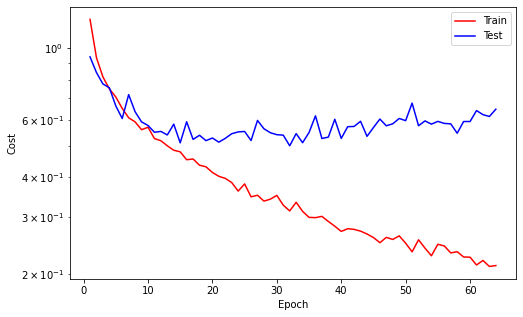

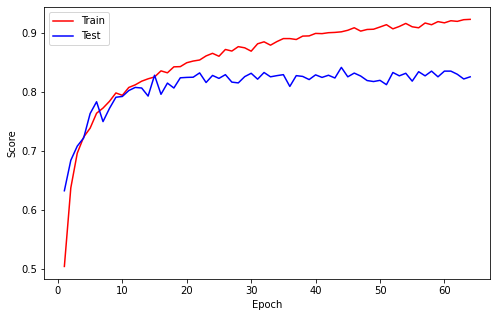

In [13]:

while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Prediksi

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

preds

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([4, 2, 3, 4, 4, 1, 4, 2, 5, 3, 4, 2, 5, 2, 2, 2, 4, 3, 4, 4, 4, 2, 4, 2,
        0, 2, 1, 3, 4, 2, 2, 4, 4, 1, 0, 2, 2, 1, 3, 2, 3, 1, 1, 2, 0, 5, 0, 0,
        3, 2, 1, 5, 5, 2, 3, 1, 2, 0, 2, 1, 5, 4, 2, 4, 5, 4, 4, 2, 3, 1, 2, 5,
        0, 2, 2, 4, 0, 4, 4, 1, 2, 3, 2, 4, 5, 2, 2, 5, 0, 2, 2, 0, 5, 5, 0, 5,
        1, 1, 1, 5, 5, 4, 1, 4, 1, 4, 4, 0, 3, 4, 0, 3, 0, 0, 2, 5, 2, 4, 2, 1,
        5, 0, 4, 4, 3, 3, 2, 4], device='cuda:0')

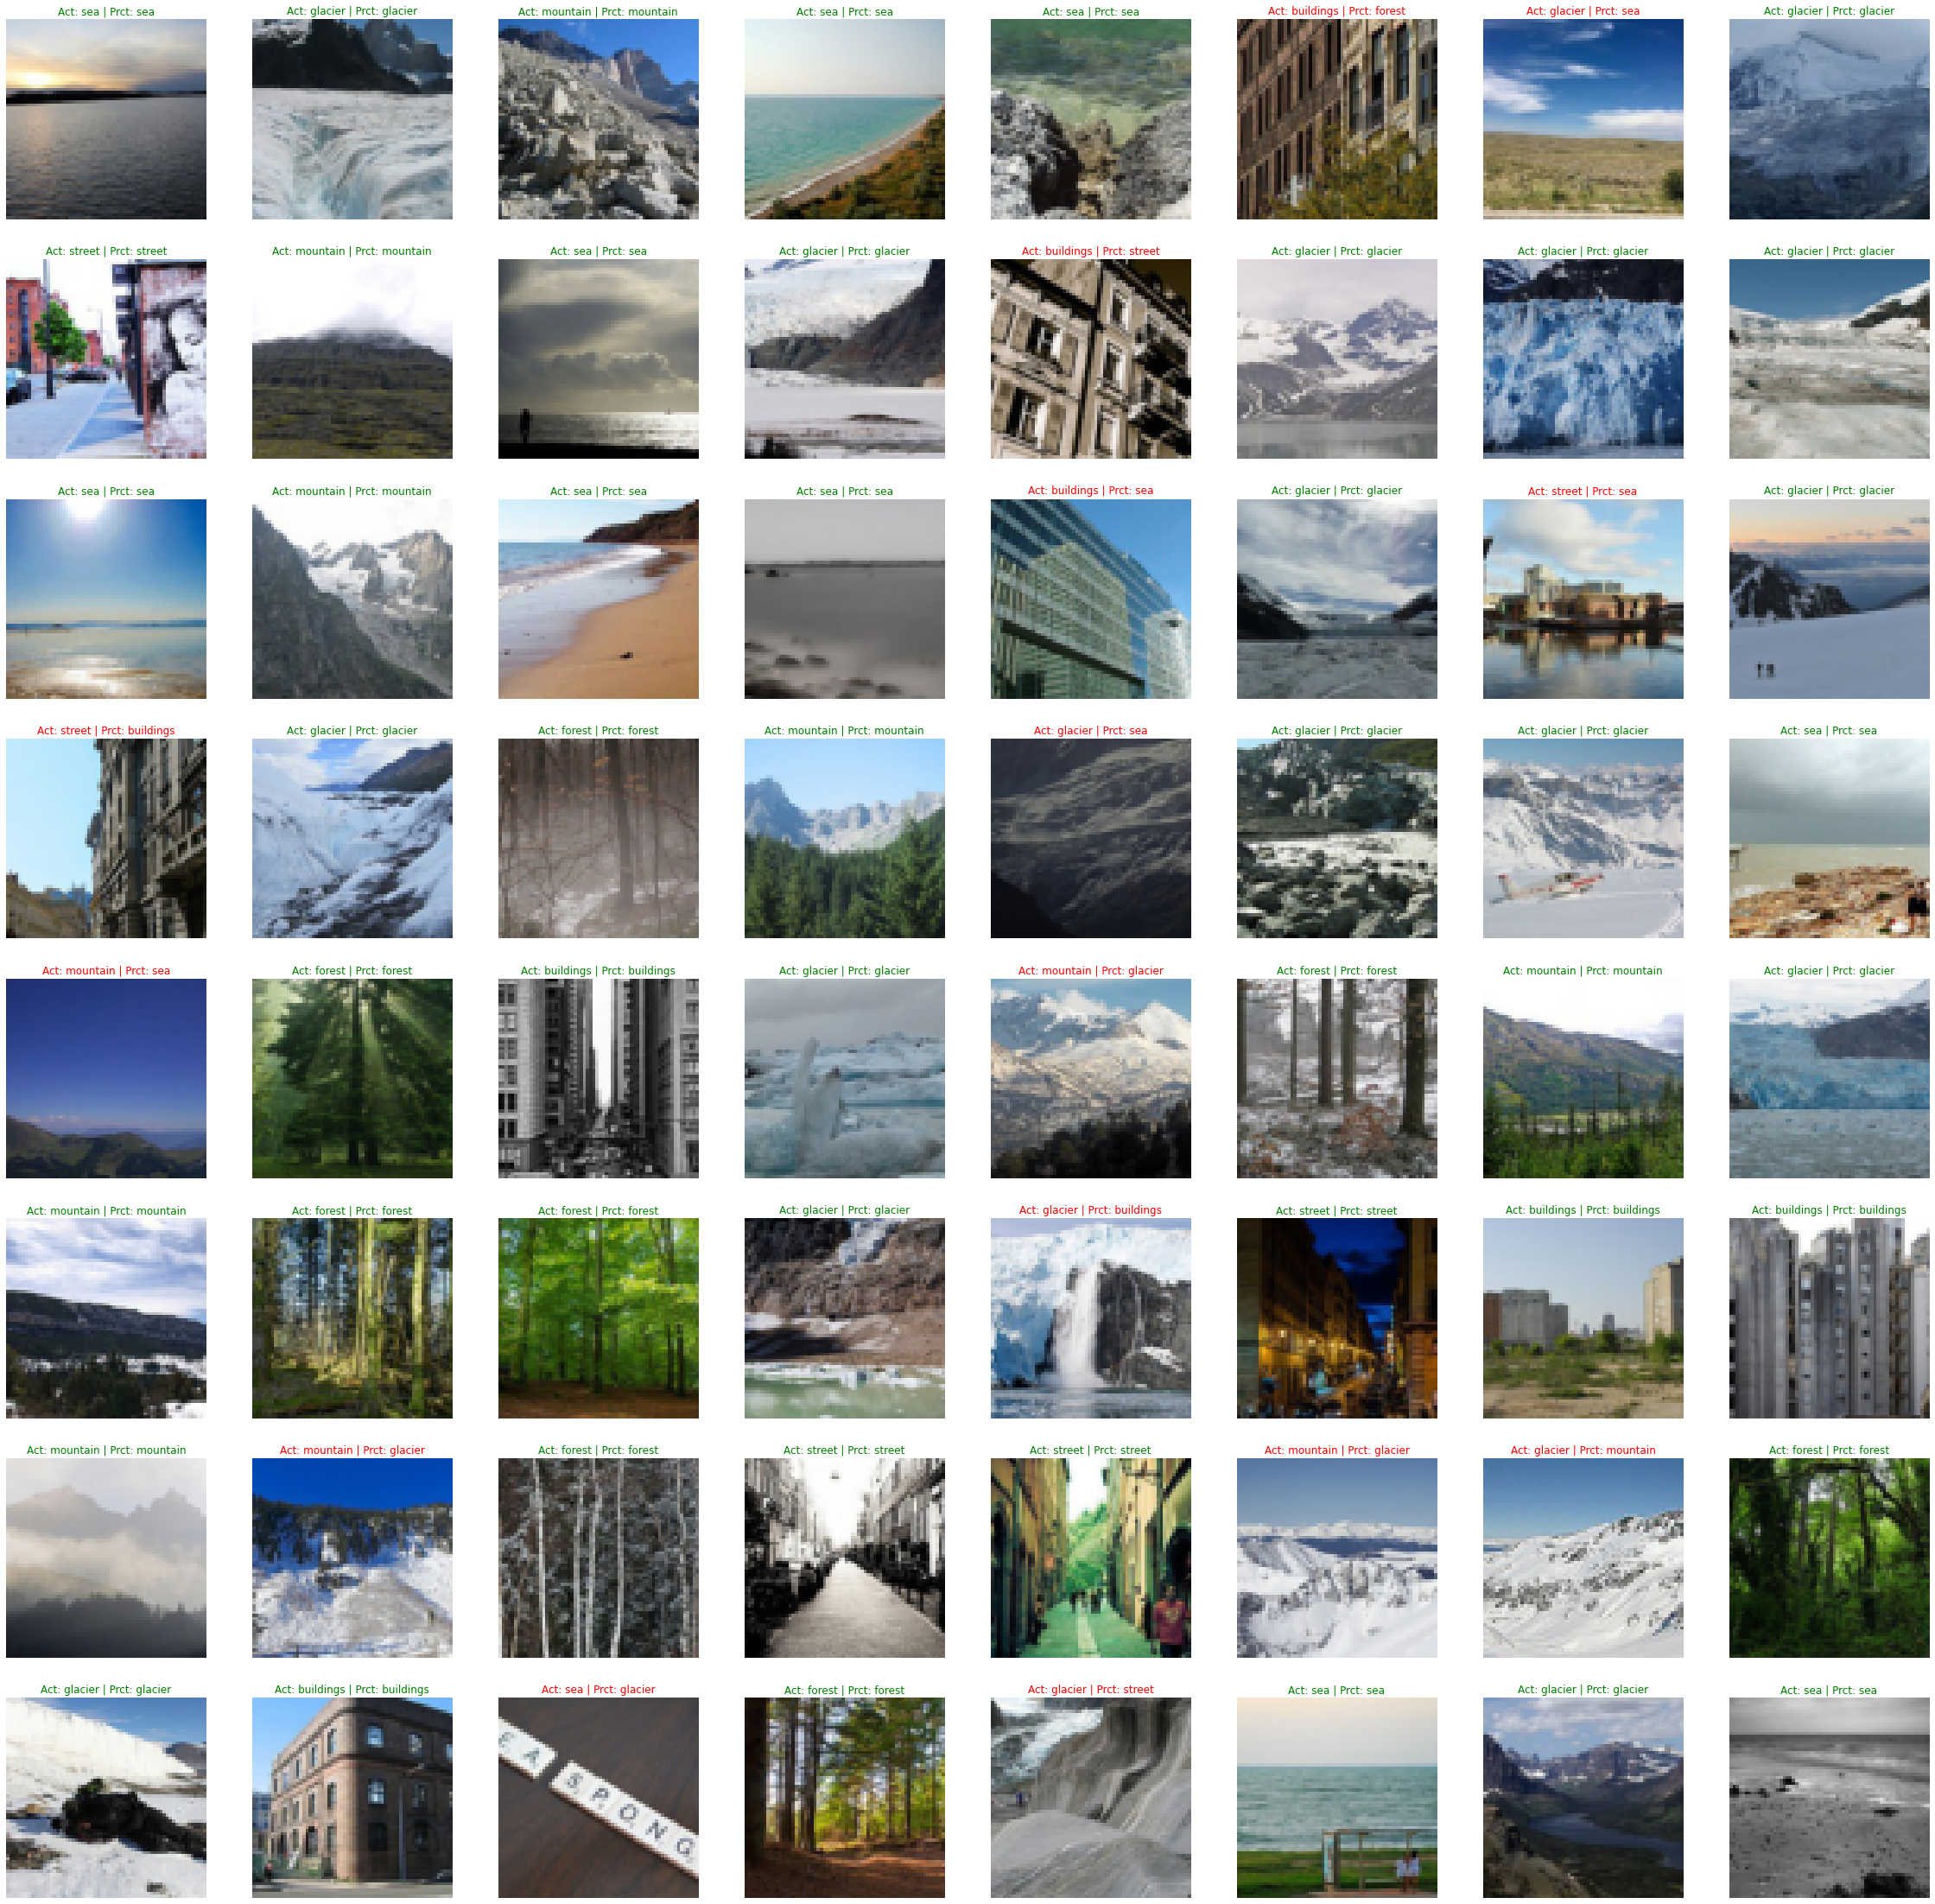

In [15]:
fig, axes = plt.subplots(8, 8, figsize=(40, 40))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color":"r"} if label != pred else {"color":"g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Act: {label} | Prct: {pred}", fontdict=font);
    ax.axis('off');